In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import os
import squidpy as sq
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import catboost
import json


from tqdm import tqdm
import sys
sys.path.append('/Users/rssantanu/Desktop/codebase/constrained_FM')


import argparse

max_rows = 1000000
pd.set_option('display.max_rows', max_rows)
pd.set_option('display.max_columns', max_rows)
pd.set_option('display.width', max_rows)


In [27]:
scRNA = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE232025_stereoseq.h5ad'))


/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [41]:
scRNA.obs['day'].value_counts()

day
3    11698
4     8243
2     4410
1     2929
0     1477
Name: count, dtype: int64

In [28]:
import liana as li

In [29]:
import re

def extract_symbol(name):
    # Try to find a gene symbol in the string
    # Look for patterns like 'SYMBOL[nr]' or 'SYMBOL[hs]' or 'SYMBOL |'
    match = re.search(r'([A-Z0-9\-]+)(?:\[.*?\])?\s*\|', name)
    if match:
        return match.group(1)
    # If not found, try to find a symbol before a space or bracket
    match = re.match(r'([A-Z0-9\-]+)', name)
    if match:
        return match.group(1)
    return None

# Apply to your var_names
symbols = [extract_symbol(x) for x in scRNA.var_names]
scRNA.var['gene_symbol'] = symbols
# Filter out None or nan
scRNA = scRNA[:, [s is not None and s != 'nan' for s in symbols]]
scRNA.var_names = scRNA.var['gene_symbol']

/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [30]:
li.method.rank_aggregate(
    adata=scRNA,
    groupby='celltype',
    resource_name='consensus',
    use_raw=False,         # <--- add this line
    verbose=True
)

Using resource `consensus`.
Using `.X`!
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable nam

Generating ligand-receptor stats for 28757 samples and 119 features
Assuming that counts were `natural` log-normalized!


/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running CellPhoneDB


100%|██████████| 1000/1000 [00:06<00:00, 162.75it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [32]:
liana_df= scRNA.uns['liana_res']

In [37]:
liana_df[(liana_df['source']=='Immature dpEX') & (liana_df['target']=='Immature nptxEX')]

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank
1746,Immature dpEX,Immature nptxEX,NPTX2,NPTXR,2.143550,0.0,4.357615,1.365654,1.332458,0.007678,0.929666,0.005622,0.000086
1741,Immature dpEX,Immature nptxEX,ADCYAP1,ADCYAP1R1,1.377188,0.0,1.872073,1.295043,1.102387,0.006018,0.896519,0.017737,0.014063
1744,Immature dpEX,Immature nptxEX,COL18A1,GPC4,0.100847,1.0,0.010036,-0.153699,-0.332736,0.000506,0.388127,1.000000,0.037799
1749,Immature dpEX,Immature nptxEX,SFRP1,FZD2,0.128034,1.0,0.015281,-0.147640,-0.403556,0.000384,0.439061,1.000000,0.326482
1742,Immature dpEX,Immature nptxEX,BCAN,NRCAM,0.553741,0.0,0.120176,0.260851,0.200984,0.001099,0.687018,0.577206,0.464679
1750,Immature dpEX,Immature nptxEX,SLIT2,GPC1,0.454449,0.0,0.089280,0.421768,0.342241,0.002060,0.654217,0.108702,0.520021
1751,Immature dpEX,Immature nptxEX,SPARC,ENG,0.406123,0.0,0.088688,0.165484,-0.008391,0.002498,0.653464,0.433426,0.526737
1743,Immature dpEX,Immature nptxEX,COL18A1,GPC1,0.443054,0.0,0.071121,0.364476,0.285944,0.001680,0.628065,0.203705,0.755583
1748,Immature dpEX,Immature nptxEX,NXPH1,NRXN3,0.545279,0.0,0.291892,0.584069,0.518965,0.003500,0.773806,0.030461,0.757053
1745,Immature dpEX,Immature nptxEX,CXCL12,AVPR1A,0.174377,0.0,0.025696,0.183585,0.097422,0.004117,0.503727,0.264798,0.928461


In [38]:
liana_df.columns

Index(['source', 'target', 'ligand_complex', 'receptor_complex', 'lr_means', 'cellphone_pvals', 'expr_prod', 'scaled_weight', 'lr_logfc', 'spec_weight', 'lrscore', 'specificity_rank', 'magnitude_rank'], dtype='object')

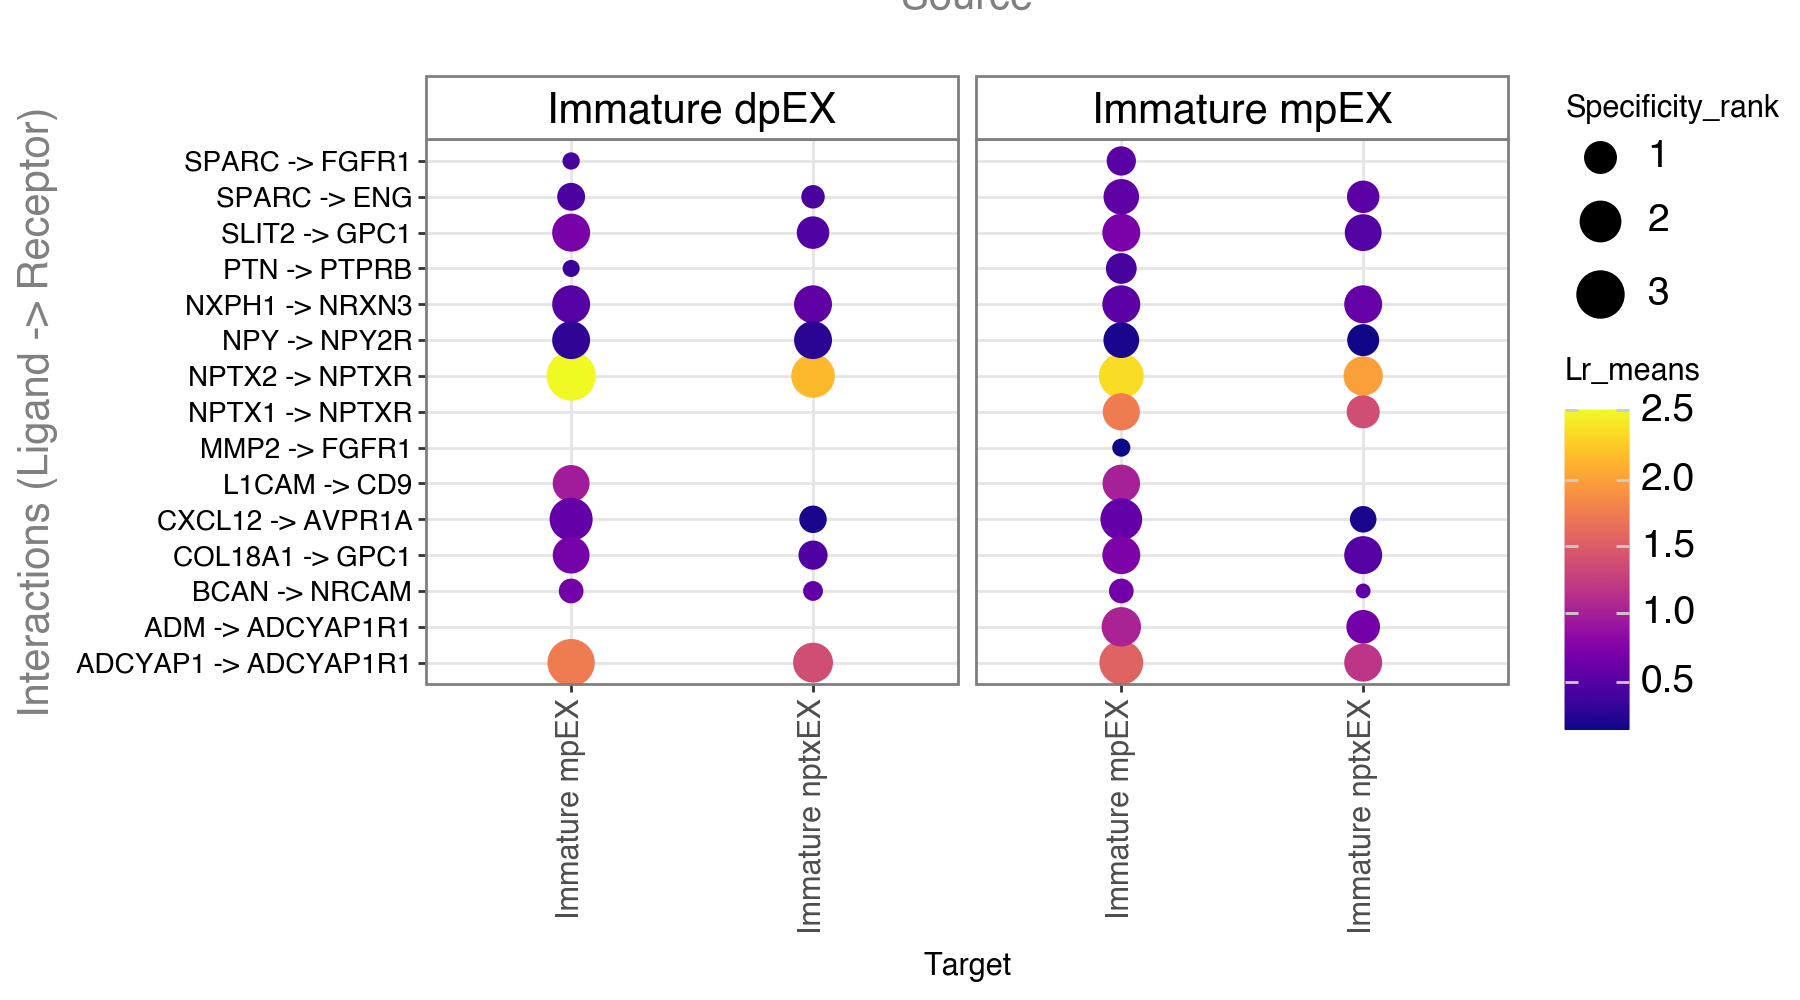

In [19]:
import liana as li

li.pl.dotplot(
    adata=scRNA,
    colour='lr_means',           # or another score column
    size='specificity_rank',     # or another ranking/stat column
    inverse_size=True,           # small p-values = big dots
    source_labels=['Immature dpEX', 'Immature mpEX'],  # replace with your cell types
    target_labels=['Immature nptxEX', 'Immature mpEX'],  # replace with your cell types
    figure_size=(9, 5),
    filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,  # filter by significance
    cmap='plasma'
)

In [22]:
li.rs.show_resources()

['baccin2019',
 'cellcall',
 'cellchatdb',
 'cellinker',
 'cellphonedb',
 'celltalkdb',
 'connectomedb2020',
 'consensus',
 'embrace',
 'guide2pharma',
 'hpmr',
 'icellnet',
 'italk',
 'kirouac2010',
 'lrdb',
 'mouseconsensus',
 'ramilowski2015']